# Group Lasso比較検証

## 目的
- データセットを利用してLassoよりもGroup Lassoが精度が高いかどうか比較する

## 評価方法
- トイデータによる予測誤差・真のモデルに一致しているかの評価

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### モデルの定義

In [2]:
class Lasso:
    def __init__(self, alpha=0.1, maxiter=100):
        self.alpha = alpha
        self.maxiter = maxiter
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2*np.linalg.eig(X.T@X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            v = z + (X.T @ res) / L
            w_new = self._soft_threshold(v,  self.alpha / L)
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
    
    def predict(self, X):
        return X @ self.w
        
    def _soft_threshold(self, y, alpha):
        return np.sign(y) * np.maximum(np.abs(y) - alpha, 0.0)

In [3]:
class GroupLasso:
    def __init__(self, group_ids, alpha=1e-3, eta=1e-1, maxiter=100):
        self.alpha = alpha
        self.eta = eta
        self.maxiter = maxiter
        self.group_ids = group_ids
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2*np.linalg.eig(X.T@X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            
            #print('loss:', np.mean(res**2))
            v = z + (X.T @ res) / L * self.eta
            #print(self.alpha * self.eta / L)
            w_new = self._proximal_operator(v,  self.alpha * self.eta )
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
        
    def _proximal_operator(self, v, thresh):
        result_w = np.zeros_like(self.w).astype(np.float64)
        for group_id in self.group_ids:
            # 該当するgroupのみ係数を抽出p
            group_coef_idx = self.group_ids == group_id
            group_coef = v[group_coef_idx]
            
            # L2ノルムの計算
            group_norm = np.linalg.norm(group_coef, 2)
            
            # soft_threshold関数
            if group_norm == 0:
                multiplier = 0
            else:
                #print(group_norm)
                multiplier = np.maximum(0, 1 -  thresh / group_norm)
            
            result_w[group_coef_idx] = multiplier * group_coef
            
        return result_w
    
    def predict(self, X):
        return X @ self.w

### トイデータの生成
#### 真のモデル
$$Y=\sum_{j=1}^{J} X_{j} \beta_{j}+\epsilon$$
ただし, $j$はグループのインデックスを表す.  
このモデルはグループ単位でスパース性を持つと仮定する.  
グループに関する情報、データサイズの例を以下に示す.    

|  |  |
|:-----------:|:------------:|
| グループ数 | 5 |
| 1グループ毎の変数の数 | 30 |
| データ数 | 100 |
| 係数が全て0であるグループの数| 2　| 

In [4]:
np.random.seed(42)
n_groups = 5
n_features = 30
n_samples = 100
n_group_zero = 2

In [5]:
def generate_data(n_groups, n_features, n_samples, n_group_zero):
    beta = np.zeros((n_groups * n_features))
    beta[n_features * n_group_zero:] = 3 * np.random.randn(n_features * (n_groups - n_group_zero))
    X = np.random.randn(n_samples, n_features * n_groups)
    y = X @ beta
    y += 0.01 * np.random.normal(size=n_samples)
    group_ids = np.array([[i for _ in range(n_features)] for i in range(n_groups)]).reshape(-1)
    return X, y, beta, group_ids

In [6]:
X, y, beta, group_ids = generate_data(n_groups, n_features, n_samples, n_group_zero)

In [7]:
print(X.shape)
print(y.shape)
print(beta.shape)

(100, 150)
(100,)
(150,)


In [8]:
alpha = 0.1
lasso = Lasso(alpha=alpha, maxiter=2000)
lasso.fit(X, y)

In [9]:
alpha = 0.2
eta = 0.2
glasso = GroupLasso(group_ids=group_ids, alpha=alpha, eta=eta, maxiter=2000)
glasso.fit(X, y)

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


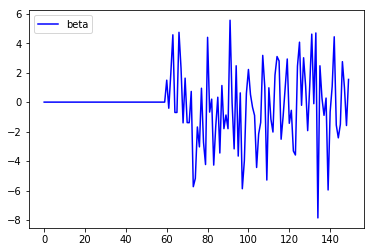

In [10]:
plt.plot(beta, '-b', label='beta')
plt.legend()
plt.show()

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


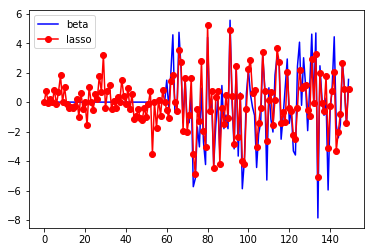

In [11]:
plt.plot(beta, '-b', label='beta')
plt.plot(lasso.w, '-ro', label='lasso')
plt.legend()
plt.show()

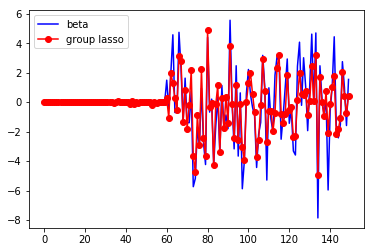

In [12]:
plt.plot(beta, '-b', label='beta')
plt.plot(glasso.w, '-ro', label='group lasso')
plt.legend()
plt.show()

In [13]:
test_samples = 1000
X_test = np.random.randn(test_samples, n_features * n_groups)
y_test = X_test @ beta
y_test += 0.01 * np.random.normal(size=test_samples)

In [14]:
print("Lasso MSE: ", np.linalg.norm(y_test - lasso.predict(X_test)))
print("Group Lasso MSE: ", np.linalg.norm(y_test - glasso.predict(X_test)))

Lasso MSE:  471.36046475079945
Group Lasso MSE:  398.2548834970038
